In [1]:
import pandas as pd
import keras
import numpy as np

# Import CIFAR 10 dataset
from keras.datasets import cifar10

from keras.preprocessing.image import ImageDataGenerator

# Import Necessary CNN Building Blocks
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU

from keras import backend as K
from keras import applications
from keras import callbacks
from keras import optimizers
from keras.utils import np_utils
import random

import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = 9,6

In [2]:
# Requirements:
# !pip install keras
# !pip install tensorflow
# !pip install keras
# !pip install tensorflow_addons

# <span style='font-family:Georgia'> Data loading & preparation

In [3]:
# Load Dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

BATCH_SIZE = 32
INPUT_SHAPE = X_train.shape[1:]
NUM_CLASSES = 10

print('x_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [4]:
# Normalize input data
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# Encode target variable
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

# <span style='font-family:Georgia'> Deep Learning pretrained models fitting with early stopping

In [5]:
early_stopping = EarlyStopping()

## <span style='font-family:Georgia'> Residual Network (ResNet)

In [6]:
LR=1e-3
EPOCHS=10
INPUT_SHAPE = X_train.shape[1:]

In [7]:
input_tensor=tf.keras.Input(shape=INPUT_SHAPE)

In [8]:
res_base = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
resNet = Sequential()
resNet.add(res_base)
resNet.add(tf.keras.layers.Flatten())
resNet.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))

In [9]:
resNet.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.RMSprop(learning_rate=LR),
               metrics=['accuracy'])

In [10]:
resNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [11]:
resNet.fit(X_train,
           y_train,
           batch_size=BATCH_SIZE,
           epochs=EPOCHS,
           shuffle=True,
           verbose=1,
           validation_data=(X_test, y_test_ohe),
           callbacks=[early_stopping]
          )

Epoch 1/10
1563/1563 [==============================] - 2701s 2s/step - loss: 2.3281 - accuracy: 0.4085 - val_loss: 2.2163 - val_accuracy: 0.3313
Epoch 2/10
1563/1563 [==============================] - 1839s 1s/step - loss: 1.7368 - accuracy: 0.5525 - val_loss: 1.9985 - val_accuracy: 0.3717


## <span style='font-family:Georgia'> VGG16

In [12]:
EPOCHS=10
BATCH_SIZE = 32
LR=1e-3
MOMENTUM=0.9
INPUT_SHAPE = X_train.shape[1:]

In [13]:
vgg_base = tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet',input_shape=INPUT_SHAPE)

vgg = Sequential()
vgg.add(vgg_base)
vgg.add(Flatten()) 
vgg.add(Dense(NUM_CLASSES, activation=('softmax')))
vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,719,818
Trainable params: 14,719,818
Non-trainable params: 0
_________________________________________________________________


In [14]:
vgg.compile(loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.SGD(learning_rate=LR, momentum=MOMENTUM),
            metrics=['accuracy'])

In [15]:
vgg_history = (
    vgg.fit(X_train,
            y_train, 
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
            validation_data=(X_test, y_test_ohe),
            validation_steps=X_test.shape[0]//BATCH_SIZE,
            verbose=1,
            callbacks=[early_stopping]
           )
)

Epoch 1/10
1562/1562 [==============================] - 1513s 968ms/step - loss: 0.1810 - accuracy: 0.6177 - val_loss: 0.1450 - val_accuracy: 0.6959
Epoch 2/10
1562/1562 [==============================] - 1493s 956ms/step - loss: 0.1211 - accuracy: 0.7545 - val_loss: 0.1138 - val_accuracy: 0.7726


# <span style='font-family:Georgia'> Models Evaluation

## <span style='font-family:Georgia'> Residual Network (ResNet)

In [16]:
resNet.evaluate(X_test, y_test_ohe)

313/313 [==============================] - 25s 79ms/step - loss: 1.9985 - accuracy: 0.3717


[1.9985486268997192, 0.3716999888420105]

In [17]:
y_pred_resnet = resNet.predict(X_test)

In [18]:
y_pred_resnet_classes = np.argmax(y_pred_resnet, axis=-1)

In [19]:
conf_matr_resnet = pd.DataFrame(confusion_matrix(y_test, y_pred_resnet_classes))
conf_matr_resnet.to_csv("../results/pretrained/conf_matr_resnet_early_stop.csv")
conf_matr_resnet

,0,1,2,3,4,5,6,7,8,9
0,830,12,7,14,3,2,0,8,28,96
1,57,335,1,6,0,1,1,5,7,587
2,465,24,199,76,42,28,36,46,39,45
3,270,45,49,244,36,47,9,98,79,123
4,432,14,83,65,167,5,43,124,19,48
5,254,31,161,184,15,130,0,115,38,72
6,115,48,36,171,66,19,234,94,31,186
7,469,23,36,34,15,17,0,290,4,112
8,318,61,0,2,2,0,0,5,426,186
9,87,20,1,2,4,0,0,8,16,862


In [20]:
print(classification_report(y_test, y_pred_resnet_classes))

              precision    recall  f1-score   support

           0       0.25      0.83      0.39      1000
           1       0.55      0.34      0.42      1000
           2       0.35      0.20      0.25      1000
           3       0.31      0.24      0.27      1000
           4       0.48      0.17      0.25      1000
           5       0.52      0.13      0.21      1000
           6       0.72      0.23      0.35      1000
           7       0.37      0.29      0.32      1000
           8       0.62      0.43      0.51      1000
           9       0.37      0.86      0.52      1000

    accuracy                           0.37     10000
   macro avg       0.45      0.37      0.35     10000
weighted avg       0.45      0.37      0.35     10000



## <span style='font-family:Georgia'> VGG16

In [21]:
vgg.evaluate(X_test, y_test_ohe)

313/313 [==============================] - 41s 131ms/step - loss: 0.1138 - accuracy: 0.7726


[0.11381202191114426, 0.772599995136261]

In [22]:
y_pred_vgg16 = vgg.predict(X_test)

In [23]:
y_pred_vgg16_classes = np.argmax(y_pred_vgg16, axis=-1)

In [24]:
conf_matr_vgg = pd.DataFrame(confusion_matrix(y_test, y_pred_vgg16_classes))
conf_matr_vgg.to_csv("../results/pretrained/conf_matr_vgg_early_stop.csv")
conf_matr_vgg

,0,1,2,3,4,5,6,7,8,9
0,793,20,27,10,8,1,5,12,67,57
1,7,886,0,5,1,2,5,2,11,81
2,56,5,667,45,64,43,79,24,7,10
3,18,19,44,588,30,144,64,41,17,35
4,21,6,76,66,633,20,78,74,16,10
5,10,6,34,147,25,679,31,52,0,16
6,6,10,23,47,15,13,860,6,8,12
7,14,6,16,38,28,37,6,821,4,30
8,29,20,5,13,4,0,2,3,889,35
9,9,46,4,6,0,2,3,3,17,910


In [25]:
print(classification_report(y_test, y_pred_vgg16_classes))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81      1000
           1       0.87      0.89      0.88      1000
           2       0.74      0.67      0.70      1000
           3       0.61      0.59      0.60      1000
           4       0.78      0.63      0.70      1000
           5       0.72      0.68      0.70      1000
           6       0.76      0.86      0.81      1000
           7       0.79      0.82      0.81      1000
           8       0.86      0.89      0.87      1000
           9       0.76      0.91      0.83      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



## <span style='font-family:Georgia'> Confusion matrices comparison

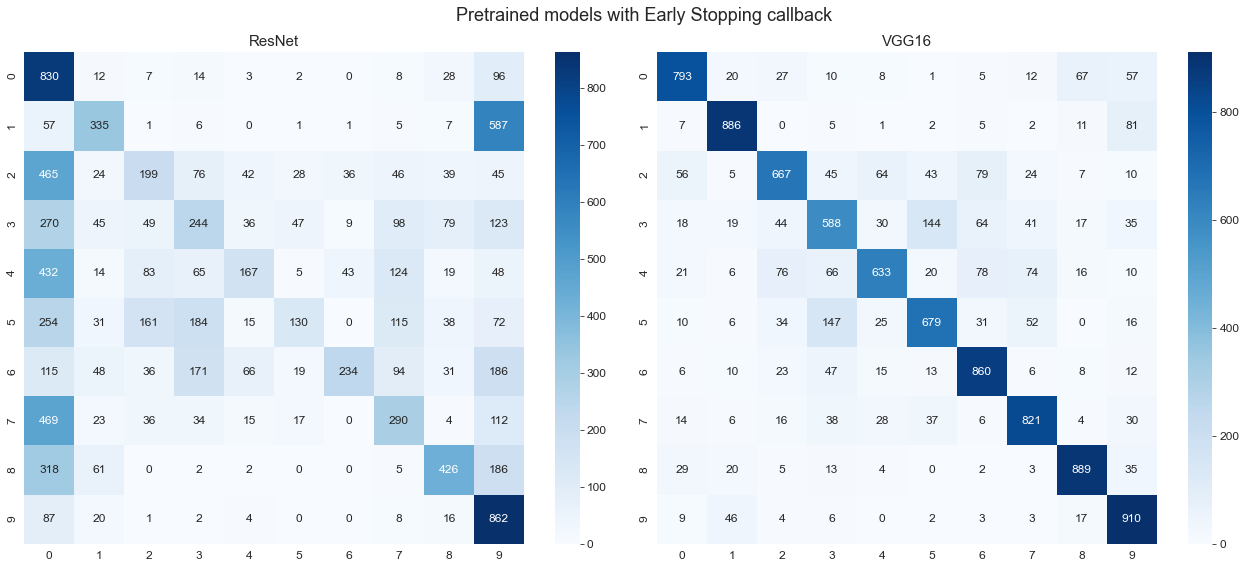

In [22]:
fig, axes = plt.subplots(1,2,figsize=(18,8))
models = ['ResNet', 'VGG16',]
models_results = [conf_matr_resnet, conf_matr_vgg]
title = "Pretrained models with Early Stopping callback"
for i in range(2):
    sns.heatmap(models_results[i], annot=True, cmap="Blues", ax=axes[i], fmt='d', annot_kws={"size": 12})
    axes[i].set_title(models[i], size=15)
    axes[i].set_xticklabels(axes[i].get_xmajorticklabels(), fontsize = 12)
    axes[i].set_yticklabels(axes[i].get_xmajorticklabels(), fontsize = 12)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=12)

fig.suptitle(title, size=18)
plt.tight_layout()
plt.show()